In [3]:
# Cellule 1 : Imports + configuration générale

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from xgboost import XGBRegressor
import joblib
import shap

# Pour que les graphes s'affichent bien dans le notebook
%matplotlib inline

# Pour que les graphiques shap interactifs (force_plot, summary_plot) fonctionnent bien
shap.initjs()

# Optionnel : fixer la seed pour la reproductibilité des samples
RANDOM_STATE = 42


C:\Users\fabri\anaconda3\envs\indy_env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
# Cellule 2 : Chargement des données d'apprentissage / validation / test

X_train = pd.read_csv("X_train_scaled-v2.csv")
X_val = pd.read_csv("X_val_scaled-v2.csv")
X_test = pd.read_csv("X_test_scaled-v2.csv")

y_train = pd.read_csv("y_train-v2.csv").squeeze()
y_val = pd.read_csv("y_val-v2.csv").squeeze()
y_test = pd.read_csv("y_test-v2.csv").squeeze()

print("X_train :", X_train.shape)
print("X_val   :", X_val.shape)
print("X_test  :", X_test.shape)

print("\ny_train :", y_train.shape)
print("y_val   :", y_val.shape)
print("y_test  :", y_test.shape)

print("\nAperçu des colonnes :")
print(X_train.columns.tolist())


X_train : (3957, 60)
X_val   : (848, 60)
X_test  : (848, 60)

y_train : (3957,)
y_val   : (848,)
y_test  : (848,)

Aperçu des colonnes :
['bedrooms', 'bathrooms', 'lat', 'lon', 'distance_to_downtown_km', 'log_living_area', 'log_house_age', 'zipcode_46032.0', 'zipcode_46033.0', 'zipcode_46037.0', 'zipcode_46038.0', 'zipcode_46055.0', 'zipcode_46060.0', 'zipcode_46062.0', 'zipcode_46074.0', 'zipcode_46075.0', 'zipcode_46077.0', 'zipcode_46107.0', 'zipcode_46112.0', 'zipcode_46123.0', 'zipcode_46142.0', 'zipcode_46143.0', 'zipcode_46168.0', 'zipcode_46201.0', 'zipcode_46202.0', 'zipcode_46203.0', 'zipcode_46204.0', 'zipcode_46205.0', 'zipcode_46208.0', 'zipcode_46214.0', 'zipcode_46216.0', 'zipcode_46217.0', 'zipcode_46218.0', 'zipcode_46219.0', 'zipcode_46220.0', 'zipcode_46221.0', 'zipcode_46222.0', 'zipcode_46224.0', 'zipcode_46225.0', 'zipcode_46226.0', 'zipcode_46227.0', 'zipcode_46228.0', 'zipcode_46229.0', 'zipcode_46231.0', 'zipcode_46234.0', 'zipcode_46235.0', 'zipcode_46236.0', 

In [7]:
# Cellule 3 : Reconstitution du jeu d'entraînement final (train + val)

X_final_train = pd.concat([X_train, X_val], axis=0).reset_index(drop=True)
y_final_train = pd.concat([y_train, y_val], axis=0).reset_index(drop=True)

print("X_final_train :", X_final_train.shape)
print("y_final_train :", y_final_train.shape)


X_final_train : (4805, 60)
y_final_train : (4805,)


In [9]:
# Cellule 4 : Chargement du modèle XGBoost final

model_path = "xgb_model_trainval.pkl"

final_model: XGBRegressor = joblib.load(model_path)

print("Modèle XGBoost chargé depuis :", model_path)
print(final_model)


Modèle XGBoost chargé depuis : xgb_model_trainval.pkl
XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.6, early_stopping_rounds=None,
             enable_categorical=False, eval_metric='rmse', feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.03, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=7, max_leaves=None,
             min_child_weight=1, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=-1, num_parallel_tree=None,
             objective='reg:pseudohubererror', predictor='gpu_predictor', ...)


In [11]:
# Cellule 5 : Sanity check rapide (prédictions sur le test)

y_test_pred_log = final_model.predict(X_test)

print("Premières prédictions log(y) :", y_test_pred_log[:5])
print("Premières vraies valeurs log(y) :", y_test[:5])

y_test_pred = np.expm1(y_test_pred_log)
y_test_true = np.expm1(y_test)

print("\nPremières prédictions en $ :", y_test_pred[:5])
print("Premières vraies valeurs en $ :", y_test_true[:5])


Premières prédictions log(y) : [12.411816 13.278925 13.597545 13.026112 12.767973]
Premières vraies valeurs log(y) : 0    12.559897
1    13.281060
2    13.790194
3    12.899197
4    12.745459
Name: log_sale_price, dtype: float64

Premières prédictions en $ : [245686.48 584740.4  804151.9  454116.66 350799.5 ]
Premières vraies valeurs en $ : 0    284900.0
1    585990.0
2    975000.0
3    399990.0
4    342990.0
Name: log_sale_price, dtype: float64


In [13]:
# Cellule 6 : Création de l'explainer et calcul complet SHAP sur tout train

explainer = shap.TreeExplainer(final_model)

# Calcul complet — pas d'échantillonnage
shap_values = explainer.shap_values(X_final_train)

base_value_log = explainer.expected_value

print("Forme shap_values :", np.array(shap_values).shape)
print("Base value (log$) :", base_value_log)


Forme shap_values : (4805, 60)
Base value (log$) : 10.321618


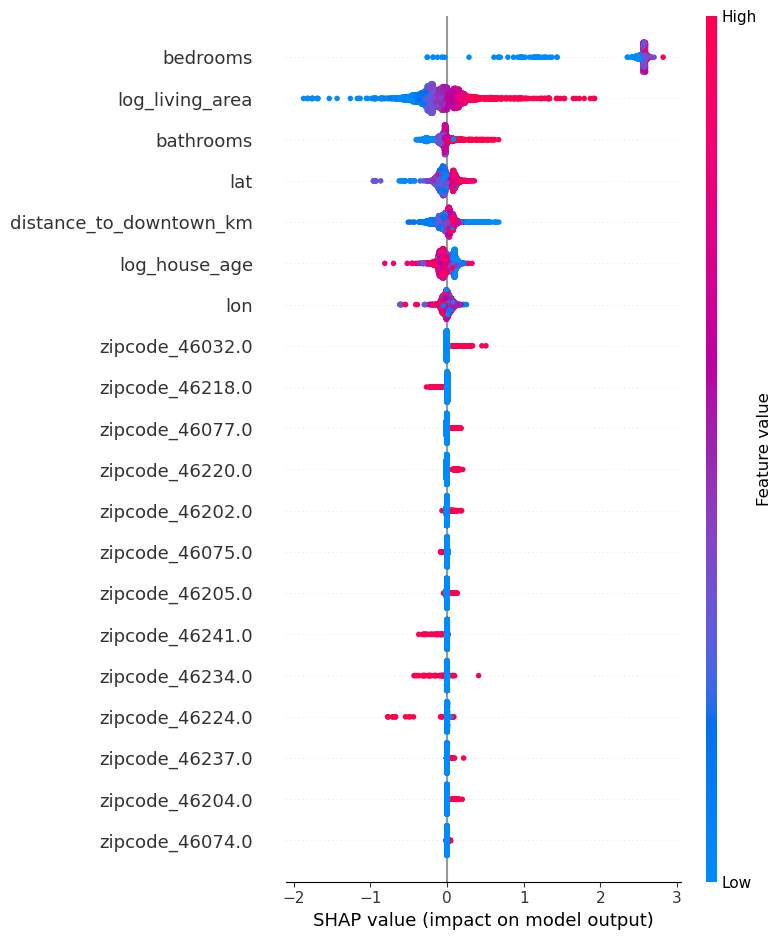

In [15]:
# Cellule 7 : Summary plot (vue globale)

plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values, X_final_train, plot_type="dot")


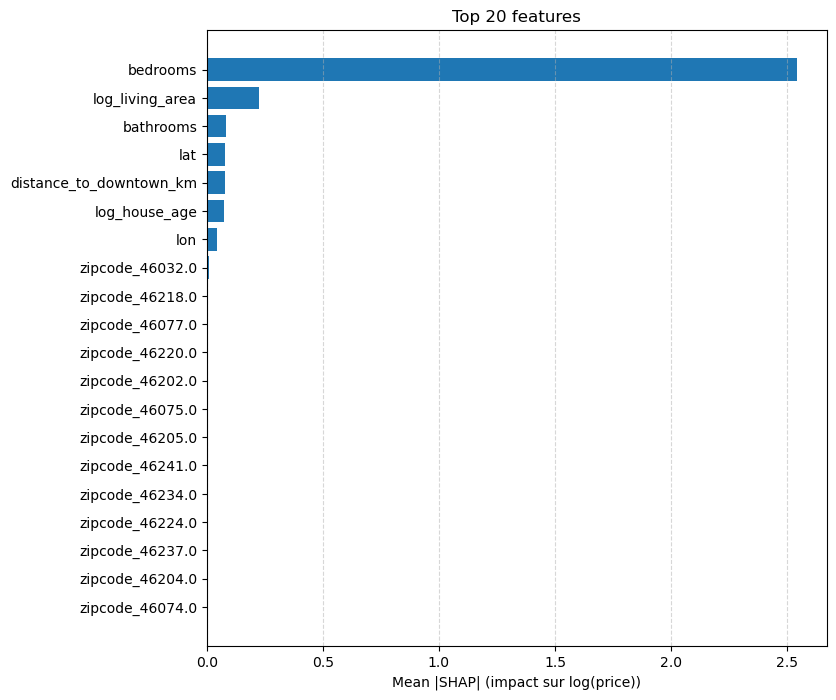

In [19]:
# Cellule 8 : Importance globale des features

mean_abs_shap = np.abs(shap_values).mean(axis=0)

feature_importance = (
    pd.DataFrame({
        "feature": X_final_train.columns,
        "mean_abs_shap": mean_abs_shap
    })
    .sort_values("mean_abs_shap", ascending=False)
)

feature_importance.head(20)
# (suite Cellule 8) — Barplot TOP 20

TOP = 20
top_feats = feature_importance.head(TOP).sort_values("mean_abs_shap")

plt.figure(figsize=(8, 8))
plt.barh(top_feats["feature"], top_feats["mean_abs_shap"])
plt.xlabel("Mean |SHAP| (impact sur log(price))")
plt.title(f"Top {TOP} features")
plt.grid(axis="x", linestyle="--", alpha=0.5)
plt.show()


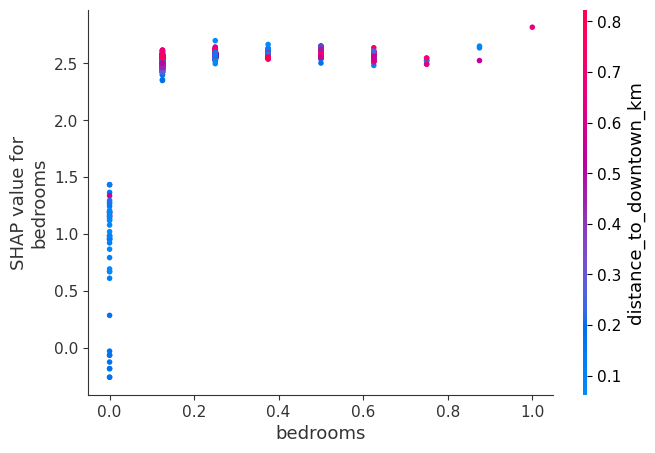

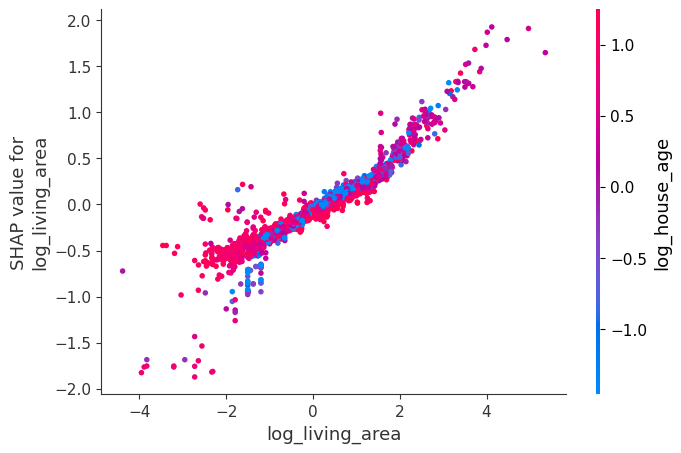

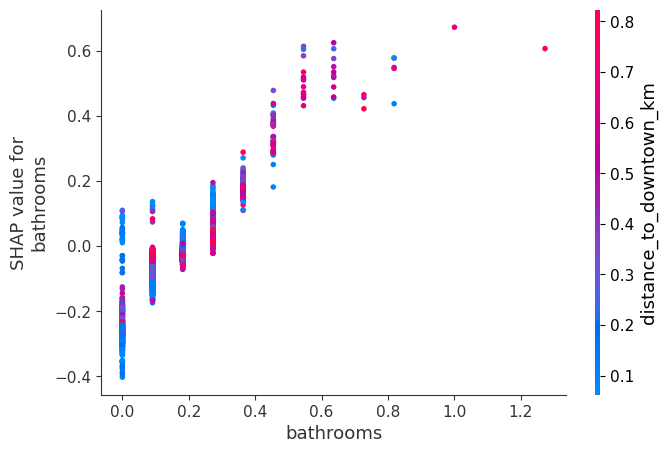

In [23]:
# Cellule 9 : SHAP dependence plots

top3 = feature_importance.head(3)["feature"].tolist()
top3
# (suite Cellule 9)

for feat in top3:
    shap.dependence_plot(feat, shap_values, X_final_train)


In [25]:
# Cellule 10 : Exemple du test

idx_example = 0
x_ex = X_test.iloc[[idx_example]]
y_true_log = y_test.iloc[idx_example]

print("Maison sélectionnée :")
display(x_ex)

print("\nPrix réel log :", y_true_log)
print("Prix réel $   :", np.expm1(y_true_log))


Maison sélectionnée :


,bedrooms,bathrooms,lat,lon,distance_to_downtown_km,log_living_area,log_house_age,zipcode_46032.0,zipcode_46033.0,zipcode_46037.0,...,zipcode_46241.0,zipcode_46250.0,zipcode_46254.0,zipcode_46256.0,zipcode_46259.0,zipcode_46260.0,zipcode_46268.0,zipcode_46278.0,zipcode_46280.0,zipcode_46290.0
0,0.375,0.090909,0.476829,0.316004,0.259087,-0.570688,0.845253,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0



Prix réel log : 12.55989703048335
Prix réel $   : 284900.00000000023


In [27]:
# Cellule 11 : SHAP local sur un exemple du test

shap_ex = explainer.shap_values(x_ex)

y_pred_log = final_model.predict(x_ex)[0]
y_pred = np.expm1(y_pred_log)

print("Prédiction log :", y_pred_log)
print("Prédiction $   :", y_pred)


Prédiction log : 12.411816
Prédiction $   : 245686.48


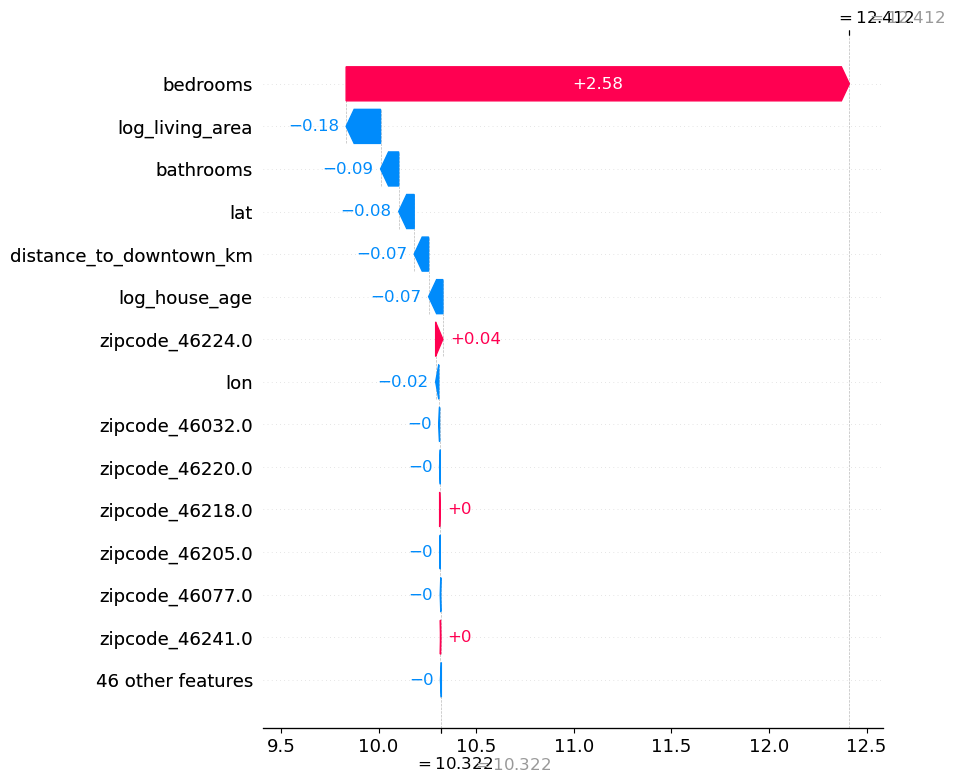

In [29]:
# Cellule 12 : Waterfall plot

shap.plots._waterfall.waterfall_legacy(
    base_value_log,
    shap_ex[0],
    feature_names=X_test.columns,
    max_display=15
)
